<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 4</h2>

In this part you will take your aligned images and combine them using the same tools that we used to combine our flats.

We took short exposures of every target to deal with saturation.  Note, however, that we can't just combine the short and long exposures and expect the saturation to go away.  In principle we would need to produced combinations of the short and long exposures separately and use photometry from faint stars from our long exposures and from the saturated stars from our bright exposures.  For the sake of expediency we are going to instead just use the long exposures and ignore the brightest stars.


In [2]:
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from matplotlib import pyplot as plt
from ccdproc import Combiner
from astropy.io import ascii
from astropy.io import fits
import os, glob, time

In [3]:
#this specifies the reduction directory
#****
#put your own path
redpath = "/home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/"

We now read in each of our combined images.  You will need to put in each combined image

In [4]:
def readimage(filename):
    imgfile = os.path.join('{}'.format(redpath), filename)
    print('Reading {}'.format(imgfile))
    img, hdr = fits.getdata(imgfile, header=True)
    return img,imgfile

This routine will display an image

In [5]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

This function will do the combination.  

In [6]:
def im_combine(comblist,outfile):
    #filelist is the name of a text file that contains a list of all the files to combine
    comblistpath = redpath + comblist
    
    #initialize a list of files to combine
    comb_imlist = []

    #this way of opening the file ensures that it closes after the loop is done.
    with open(comblistpath,'r') as fp:
        
        #read first line
        iline = 0
        line = fp.readline()

        #build the combine list of all images
        #read every subsequent line
        while line:
            #this removes the trailing newline charactter and converts the output list to a scalar
            imname = line.split()
            if(imname):
                imname = imname[0]

                #create the image name, including the path
                imstr = redpath + imname
                #read that into a CCDData object.  This allows you to specify a unit
                im = CCDData.read(imstr)

                #read in the image headers
                imtest, hdr = fits.getdata(imstr, header=True) 

                #normalize each image by its exposure time.  This allows you to combine images of 
                #different exposure times.
                im = im.divide(hdr['EXP_TIME'] * u.electron)

                #make a list of all the CCDData instances of each image
                comb_imlist = comb_imlist + [im]
        
        
            line = fp.readline()
            iline = iline + 1

    #Combiner list of all bias images
    im_combiner = Combiner(comb_imlist)


    #generate a median combined image
    combined_img = im_combiner.median_combine()

    #now write out this file
    combined_imgpath = redpath + outfile
    #this takes the header of the last file in the list writes it as the header of the combined file.
    combined_img.meta = hdr
    combined_img.write(combined_imgpath, overwrite=True)



In [7]:
#*********
#Here you will need to provide names of lists of your images, and the name of an output file 
#for each combined image
im_combine('novaBcomb','nova_B_comb.fits')
im_combine('novaVcomb','nova_V_comb.fits')
im_combine('novaRcomb','nova_R_comb.fits')
im_combine('clusterBcomb','ngc7128_B_comb.fits')
im_combine('clusterVcomb','ngc7128_V_comb.fits')

<h3> Determine the Astrometry of your image </h3>
   
"Astrometry" is the process of determining where your data are pointing, i.e.,figuring out the transformation matrix between pixel coordinates (x,y) and celestial coordinates (RA,Dec), which has a long, rich history. In a nutshell, this transformation matrix is determined by comparing the observed positions of stars (or other reference sources) against their known positions (i.e., using an external, calibrated catalog).

Needless to say there are many intricacies involved in astrometry, which I encourage you to delve into.  But for now we can proceed with just the basics and use the [astrometry.net](http://astrometry.net) engine to determine the astrometric solution of our data.

Firs we write a routine to read in images.

In [8]:
#******
#This reads in images into variables that we will use.  You will need to do this for
#every image that you combined
img_nova_B, imgfile_nova_B = readimage('nova_B_comb.fits')
img_nova_V, imgfile_nova_V = readimage('nova_V_comb.fits')
img_nova_R, imgfile_nova_R = readimage('nova_R_comb.fits')
img_ngc7128_B, imgfile_ngc7128_B = readimage('ngc7128_B_comb.fits')
img_ngc7128_V, imgfile_ngc7128_V = readimage('ngc7128_V_comb.fits')

Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/nova_B_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/nova_V_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/nova_R_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/ngc7128_B_comb.fits
Reading /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/ngc7128_V_comb.fits


First, we need the observed positions of the stars in this image, but in order to detect those stars we first have to model and subtract the sky background from the data.  This is because we want to detect stars at a certain level above the 

We'll build the sky background by measuring the median pixel value in a "low-resolution" mesh grid, which we will then interpolate onto the original resolution of the image. For additional details see the photutils tutorial on Background Estimation.

In [9]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=3.)
    bkg = Background2D(img, (100, 100), filter_size=(5, 5), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

You will need to repeat these commands for each combined image and band combination

In [10]:
#***********
bkg = get_sky_background(img_nova_B, verbose=True)
bkg = get_sky_background(img_nova_V, verbose=True)
bkg = get_sky_background(img_nova_R, verbose=True)
bkg = get_sky_background(img_ngc7128_B, verbose=True)
bkg = get_sky_background(img_ngc7128_V, verbose=True)

Sky background median = 3.564, rms = 0.070 electrons.
Sky background median = 3.741, rms = 0.071 electrons.
Sky background median = 6.125, rms = 0.115 electrons.
Sky background median = 3.151, rms = 0.061 electrons.
Sky background median = 3.344, rms = 0.064 electrons.


In [11]:
#***********
img_nova_B_nosky = img_nova_B - bkg.background
img_nova_V_nosky = img_nova_V - bkg.background
img_nova_R_nosky = img_nova_R - bkg.background
img_ngc7128_B_nosky = img_ngc7128_B - bkg.background
img_ngc7128_V_nosky = img_ngc7128_V - bkg.background

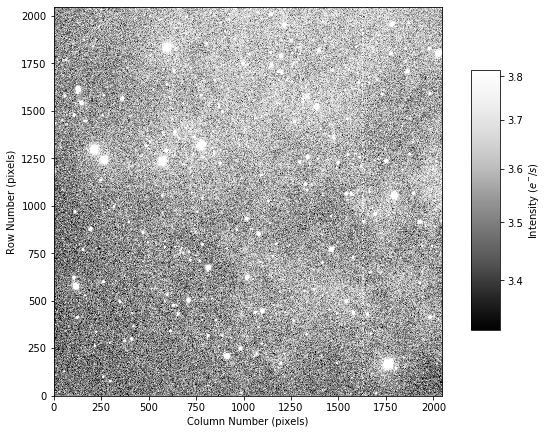

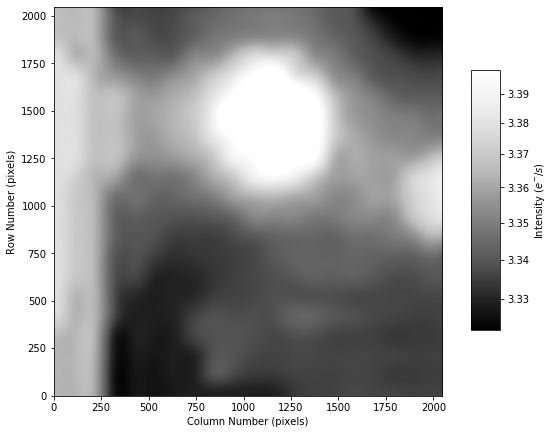

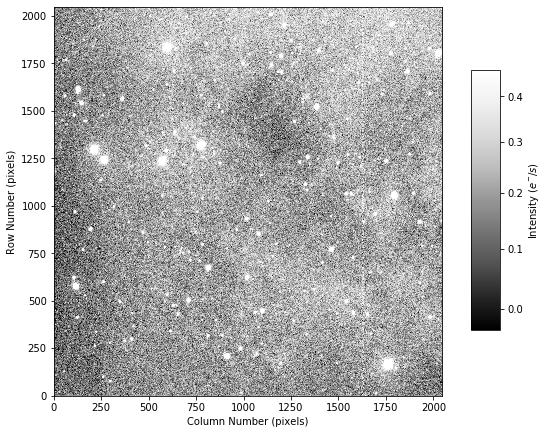

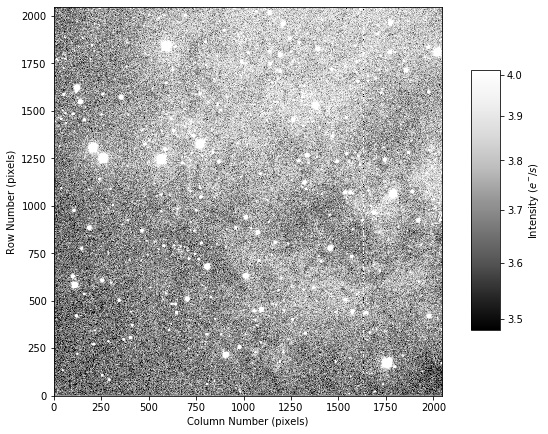

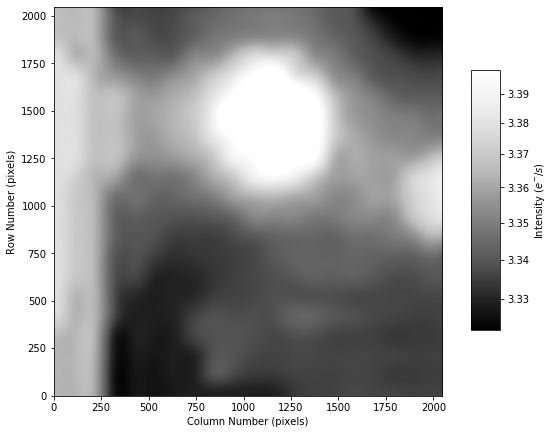

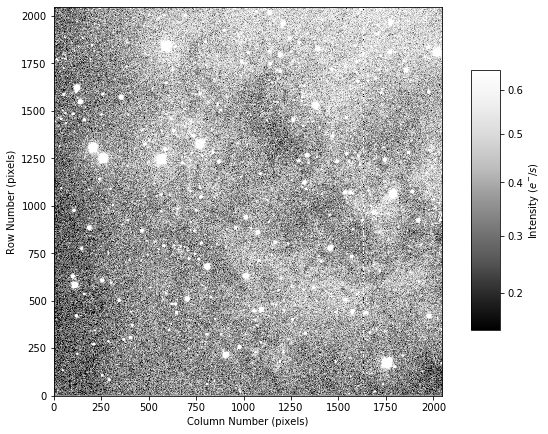

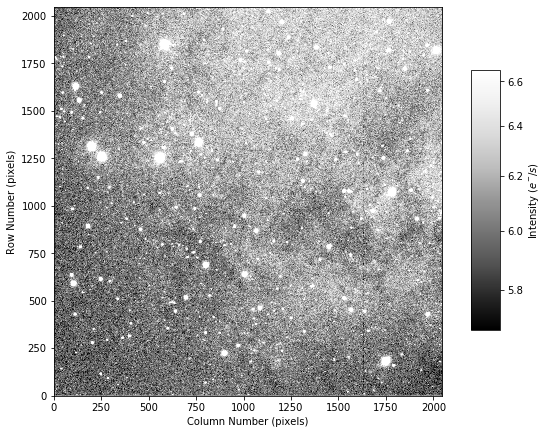

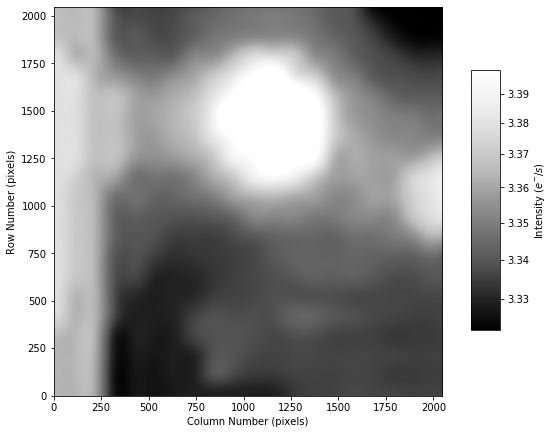

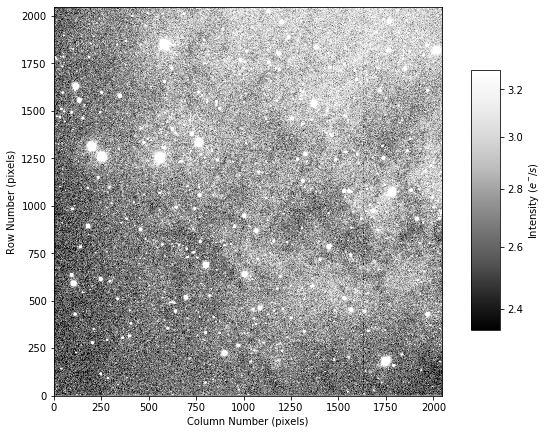

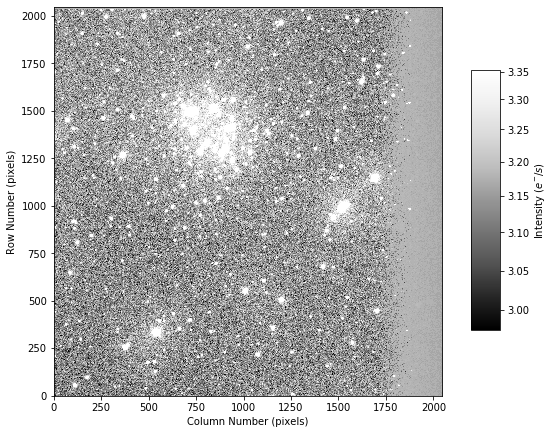

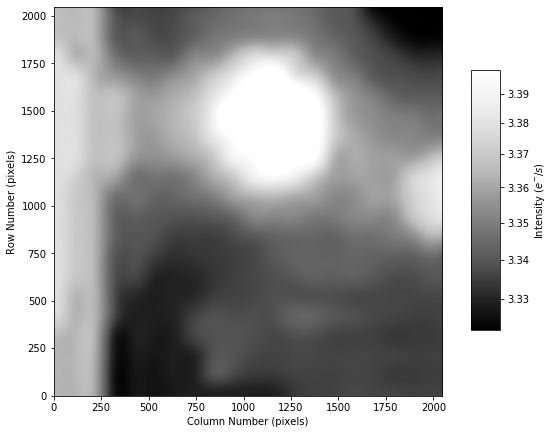

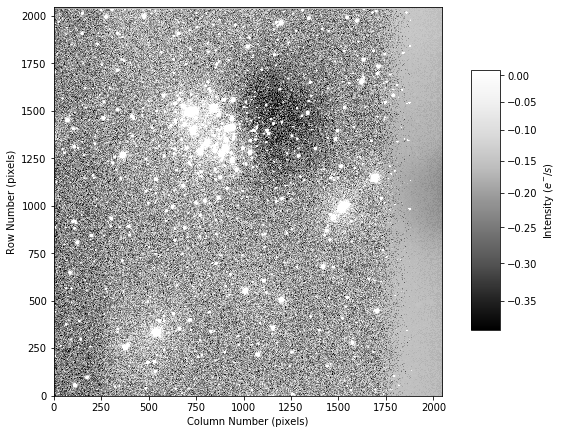

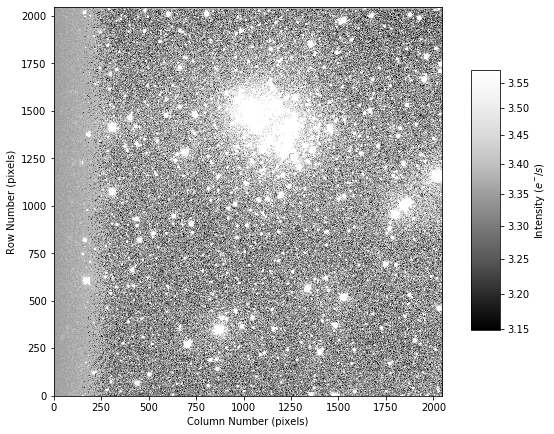

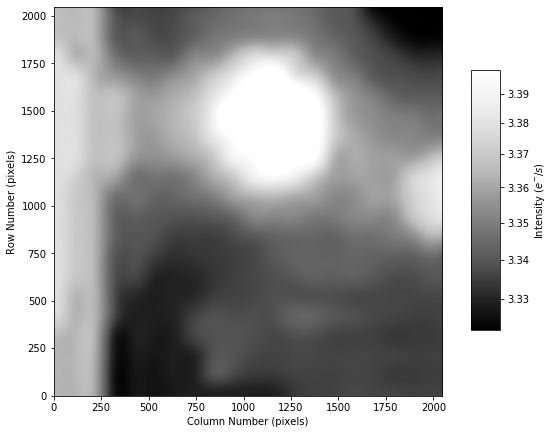

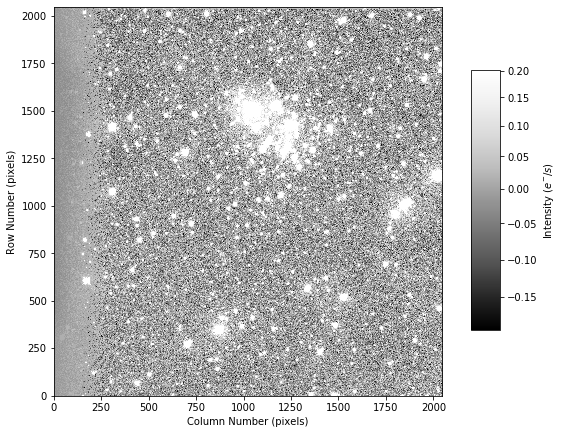

In [12]:
#***********
display_image(img_nova_B, calibrated=True)
display_image(bkg.background, calibrated=True)
display_image(img_nova_B_nosky,calibrated=True)
display_image(img_nova_V, calibrated=True)
display_image(bkg.background, calibrated=True)
display_image(img_nova_V_nosky,calibrated=True)
display_image(img_nova_R, calibrated=True)
display_image(bkg.background, calibrated=True)
display_image(img_nova_R_nosky,calibrated=True)
display_image(img_ngc7128_B, calibrated=True)
display_image(bkg.background, calibrated=True)
display_image(img_ngc7128_B_nosky,calibrated=True)
display_image(img_ngc7128_V, calibrated=True)
display_image(bkg.background, calibrated=True)
display_image(img_ngc7128_V_nosky,calibrated=True)

This routine makes histogrames of the original and background subtracted images.

In [13]:
def qa_background(img,img_nosky):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

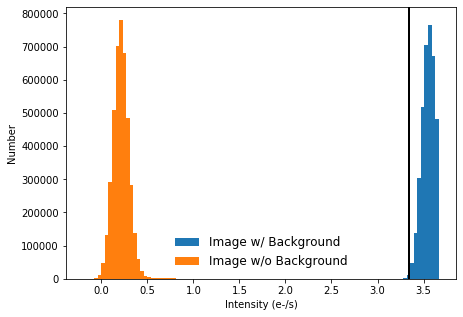

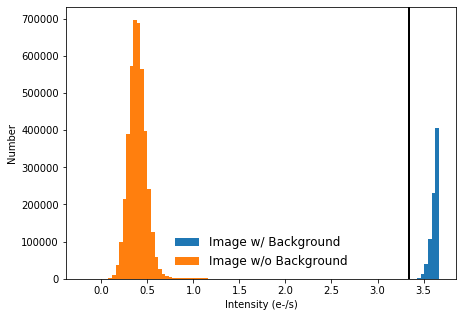

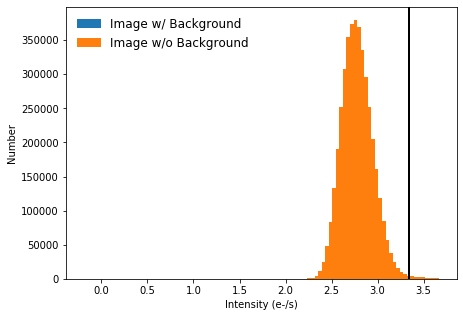

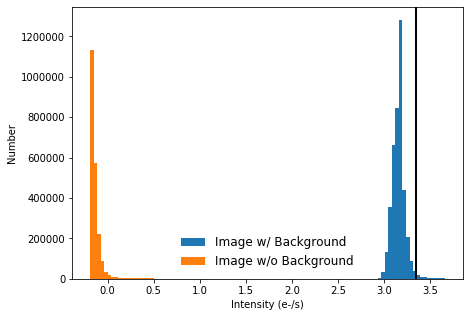

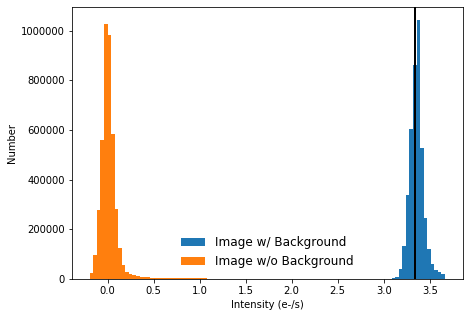

In [14]:
#***********
qa_background(img_nova_B, img_nova_B_nosky)
qa_background(img_nova_V, img_nova_V_nosky)
qa_background(img_nova_R, img_nova_R_nosky)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky)
qa_background(img_ngc7128_V, img_ngc7128_V_nosky)

In [15]:
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [16]:
#***********
srcs = find_stars(img_nova_B_nosky, imgfile_nova_B, sigma=bkg.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs = find_stars(img_nova_V_nosky, imgfile_nova_V, sigma=bkg.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs = find_stars(img_nova_R_nosky, imgfile_nova_R, sigma=bkg.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs = find_stars(img_ngc7128_V_nosky, imgfile_ngc7128_V, sigma=bkg.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)

Read 225 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-nova_B_comb.fits
Read 340 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-nova_V_comb.fits
Read 4125 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-nova_R_comb.fits
Read 632 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-ngc7128_B_comb.fits
Read 1673 stars from /home/k537d903/RFSLAB/USER_DPT/k537d903/astr596/data/reduced/stars-ngc7128_V_comb.fits


Visualize the image again with the detected sources overlaid.

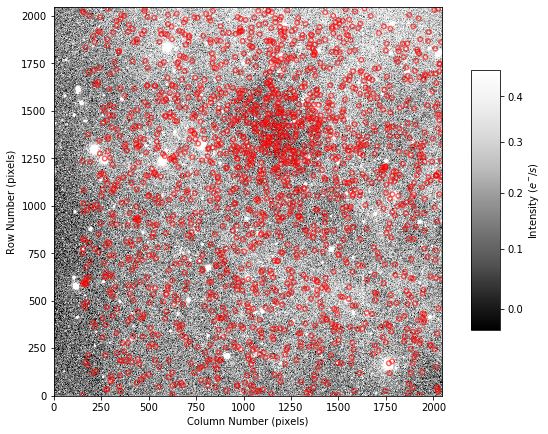

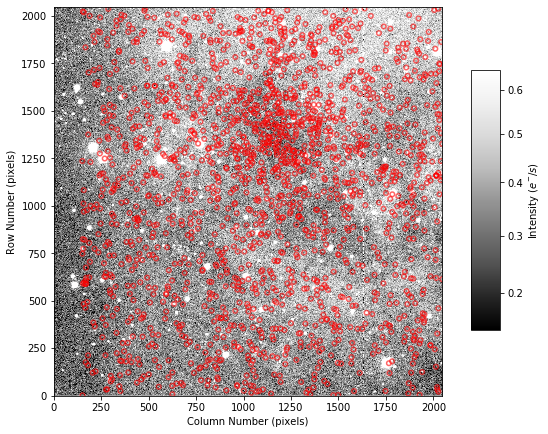

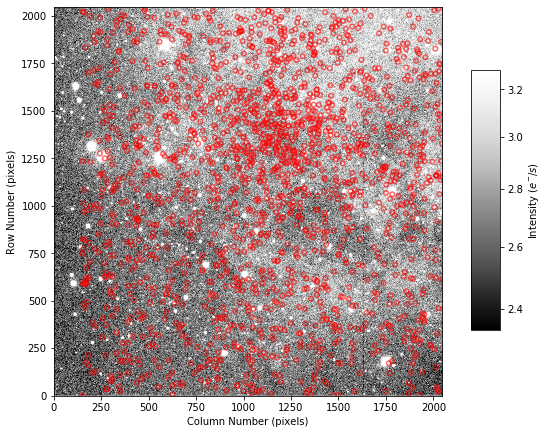

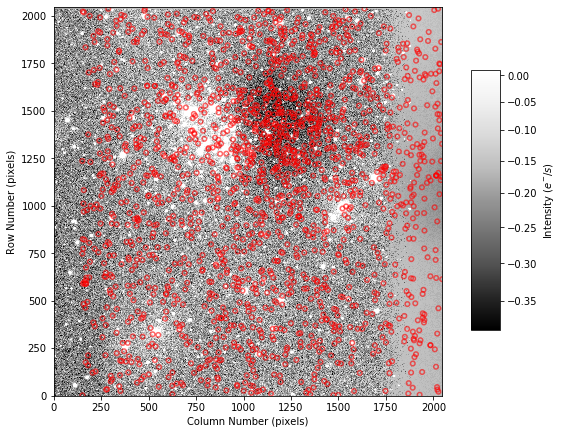

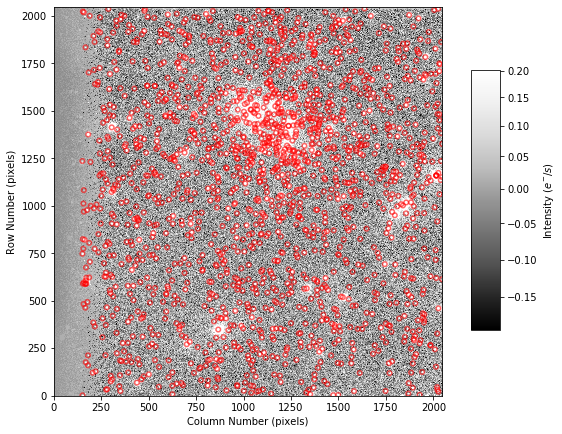

In [17]:
#***********
display_image(img_nova_B_nosky, srcs=srcs, calibrated=True)
display_image(img_nova_V_nosky, srcs=srcs, calibrated=True)
display_image(img_nova_R_nosky, srcs=srcs, calibrated=True)
display_image(img_ngc7128_B_nosky, srcs=srcs, calibrated=True)
display_image(img_ngc7128_V_nosky, srcs=srcs, calibrated=True)

Now we're ready to find the astrometric solution by uploading our table of sources (actually, their x,y positions) to astrometry.net, which returns a FITS header with the transformation matrix we need / want. For this next step you'll need your astrometry.net API key, which you can find (if you're logged in) at this site http://nova.astrometry.net/api_help.

Please do not use my API key!

In [18]:
from astroquery.astrometry_net import AstrometryNet
AstrometryNet.key = 'kcxeihqxjmzrcfqd'

def get_astrometry(imgfile, srcs=None, api_key=None, prefix='w', overwrite=False):
    from astropy.io import fits
    import astropy.units as u
    from astropy.coordinates import SkyCoord


    wcsfile = os.path.join(redpath, '{}{}'.format(prefix, os.path.basename(imgfile)))
    if not os.path.isfile(wcsfile) or overwrite:
        img, hdr = fits.getdata(imgfile, header=True)

        # Initialize the API.
        ast = AstrometryNet()
        if api_key:
            ast.api_key = api_key
        #ast.show_allowed_settings()

        # Get the initial position center based on the header.
        c = SkyCoord(hdr['RA']+hdr['DEC'], unit=(u.hourangle, u.deg))
        print('Initial RA, Dec = {:.5f}, {:.5f}'.format(c.ra.value, c.dec.value))

        # Query the astrometry.net engine!
        t0 = time.time()
        #wcshdr = ast.solve_from_source_list(
            #srcs['xcentroid'], srcs['ycentroid'], hdr['naxis1'], hdr['naxis2'],
            #center_ra=c.ra.value, center_dec=c.dec.value, radius=15/60.0, 
            #scale_type='ev', scale_est=0.4, scale_err=10, scale_units='arcsecperpix',
            #crpix_center=True,solve_timeout=180)
        wcshdr = ast.solve_from_image(imgfile)
        #print('Total time = {:.3f} min'.format((time.time() - t0)/60))

        # update the original header
        for key in wcshdr.keys():
            if key not in hdr and key != 'COMMENT' and key != 'HISTORY':
                hdr[key] = wcshdr[key]

        print('Writing {}'.format(wcsfile))
        fits.writeto(wcsfile, img, header=wcshdr, overwrite=True)        
    else:
        wcshdr = fits.getheader(wcsfile)

    return wcsfile, wcshdr

This does the astrometric calibration, which means it writes a new version of your image starting with 'w' that now contains a header that allows software, e.g. DS9 to translate between pixel and sky coordinates.

To use this you will need to get an account an astrometry.net and get your own API key.  **Do not use mine**

Running this on a single image can take time

In [24]:
#***********
my_api = 'kcxeihqxjmzrcfqd'
%time wcsfile, wcshdr = get_astrometry(imgfile_ngc7128_B, srcs, api_key=my_api, overwrite=True)
wcshdr

Initial RA, Dec = 325.98750, 53.71500
Determining background stats


Finding sources
Found 660 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
491  710.1522737275719 ... 1379.5358665820297    -7.849332490483407
 68   538.846260806793 ... 1081.0716543248463    -7.584636200763395
498  838.3264043638819 ...  900.9389714751802    -7.386738433470869
228 1511.4802241803554 ...   783.105535724197    -7.234550734947309
294 1686.9065746249862 ...  670.2084058631153    -7.065524676314057
382  900.7088386712777 ...  469.9222511433257    -6.680065024134157
446  933.7313295314838 ... 464.73815638760243   -6.6680208270347965
439  730.4748820441358 ... 438.48590824651035    -6.604889102184912
235 1528.4415483992152 ... 400.95250029166345    -6.507732315072303
359  361.0238428547776 ... 398.16561726720084    -6.500159386868926
...                ... ...                ...                   ...
115 1059.2104471138982 ... 1.0280577381525953 -0.030043765872141484
271  1611.2187

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        326.007117322 / RA  of reference point                         
CRVAL2  =        53.8111388065 / DEC of reference point                         
CRPIX1  =        777.8954703

In [25]:
%time wcsfile, wcshdr = get_astrometry(imgfile_ngc7128_V, srcs, api_key=my_api, overwrite=True)
wcshdr

Initial RA, Dec = 325.98750, 53.71500
Determining background stats


Finding sources
Found 1607 sources
 id      xcentroid      ...        flux                 mag          
---- ------------------ ... ------------------ ----------------------
 190  866.9474044350029 ... 2142.9296891648182      -8.32751980451932
 616 1839.8179407033103 ... 2064.5583426956246     -8.287067900459293
 362 169.74656589740246 ... 2057.5145913710944     -8.283357309503575
 758 2015.3686697742196 ... 2023.0187103810697     -8.264999748669073
1195 1167.2030405705045 ...  1829.148960180645     -8.155622686258326
1067 1237.3416347240945 ...  1733.044487567352     -8.097024278188469
 754 2015.2342902983748 ... 1629.8854814283002     -8.030392727986966
1070 1262.4538362877822 ... 1583.1127265400637     -7.998779600439658
 627 1856.7922297208602 ... 1502.4825932855656    -7.9420236231780965
 749 2015.2410028148227 ...  1496.409712624012     -7.937626295937385
 ...                ... ...                ...                    ...
 941 1771.4380353637375 ... 1.0129354204453704    -0.01

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =         326.08522245 / RA  of reference point                         
CRVAL2  =        53.7794143704 / DEC of reference point                         
CRPIX1  =        640.7586846

In [20]:
%time wcsfile, wcshdr = get_astrometry(imgfile_nova_B, srcs, api_key=my_api, overwrite=False)
wcshdr

Initial RA, Dec = 11.37004, 41.90275
Determining background stats


Finding sources
Found 158 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
  8  1756.647122606248 ... 506.03072971960904     -6.760442227585787
  6  1755.531672738196 ...  339.5105940679512     -6.327133326316467
  5  1756.663388090391 ...  314.1825162198765      -6.24295503386922
  7 1756.9632327144761 ...  295.6413809806995     -6.176913055648104
 96 210.56734235666428 ... 286.19430867321245      -6.14165248257062
145  594.7930532808992 ...  276.3403039332675     -6.103610577286769
139 2022.4190736673897 ... 219.18496974284687    -5.8520269244675704
 88 264.22194683673814 ... 209.07878119560812     -5.800774899389269
 87  568.9933550111427 ... 183.07259091146548     -5.656558319698163
 98  773.3687374102875 ... 174.35405700608078     -5.603580143330099
...                ... ...                ...                    ...
105  7.612378713740268 ... 1.0854414440421902   -0.08901599919674827


SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        11.4378021423 / RA  of reference point                         
CRVAL2  =        41.8889929839 / DEC of reference point                         
CRPIX1  =        622.0014980

In [21]:
%time wcsfile, wcshdr = get_astrometry(imgfile_nova_V, srcs, api_key=my_api, overwrite=False)
wcshdr

Initial RA, Dec = 11.37004, 41.90275
Determining background stats


Finding sources
Found 212 sources
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  9 1750.4041724881965 ...  437.2138969508454   -6.6017348941339415
189   2016.21408950371 ... 311.76431613708655    -6.234566013248026
196   588.754077339651 ...   288.884005724153    -6.151808743689497
195  589.0185257830335 ... 285.26593123005284     -6.13812476946621
 94 1781.9294704087567 ...  284.2114625123728    -6.134103973611678
194  588.1496662279039 ... 278.54180433174844    -6.112225961324854
111  562.3607977163114 ... 270.37518535003295     -6.07991707542179
114  257.9360015175716 ...  267.5849945114518    -6.068654389110968
126  204.3702237860845 ...  267.3247644242213    -6.067597981951279
115 258.61144496307713 ... 261.38624853646843    -6.043206839310389
...                ... ...                ...                   ...
  6 45.196957581413734 ... 1.0975521934041015   -0.1010629550152829
 25  215.47877

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        11.3573998496 / RA  of reference point                         
CRVAL2  =        41.9107803535 / DEC of reference point                         
CRPIX1  =        1215.454173

In [22]:
%time wcsfile, wcshdr = get_astrometry(imgfile_nova_R, srcs, api_key=my_api, overwrite=False)
wcshdr

Initial RA, Dec = 11.37004, 41.90275
Determining background stats


Finding sources
Found 236 sources
 id     xcentroid      ...        flux                 mag          
--- ------------------ ... ------------------ ----------------------
 15 1743.7791883324721 ... 501.70142940073055     -6.751113345951706
219  581.9476610864433 ... 495.30891504808886     -6.737190362260535
132  556.2247420576316 ... 463.29409454827174     -6.664641911087187
 10 1743.9068131590268 ...  415.3916787133801     -6.546144480828355
211  582.2488199052775 ... 403.13516591470574      -6.51362670945219
143 197.88579139263024 ... 389.68317059496036    -6.4767791253646685
107 1775.3793326684563 ...  369.2887509405778     -6.418415196565565
140  197.5751274361131 ... 290.62007585447503     -6.158314029478865
127  251.4725785636369 ...  278.3807883406206     -6.111598150931511
125  556.4365800399806 ...  275.3005312554245      -6.09951762366201
...                ... ...                ...                    ...
130  1676.915943672952 ...   1.06560232423033   -0.06898789771333629


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

SIMPLE  =                    T / Standard FITS file                             
BITPIX  =                    8 / ASCII or bytes array                           
NAXIS   =                    0 / Minimal header                                 
EXTEND  =                    T / There may be FITS ext                          
WCSAXES =                    2 / no comment                                     
CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) projection + SIP distortions            
CTYPE2  = 'DEC--TAN-SIP' / TAN (gnomic) projection + SIP distortions            
EQUINOX =               2000.0 / Equatorial coordinates definition (yr)         
LONPOLE =                180.0 / no comment                                     
LATPOLE =                  0.0 / no comment                                     
CRVAL1  =        11.3573998496 / RA  of reference point                         
CRVAL2  =        41.9107803535 / DEC of reference point                         
CRPIX1  =        1215.454173

Now repeat the necessary function calls to astrometrically calibrate all your images